In [1]:
from __future__ import division, print_function

import tensorflow as tf
import gpflow
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

import safe_learning
import plotting
np.random.seed(0)

try:
    session.close()
except NameError:
    pass

session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())

### Goal:

Optimize over the policy such that the safe set does not shrink

We start by defining a discretization of the space $[-1, 1]$ with discretization constant $\tau$

In [2]:
# x_min, x_max, discretization\
state_limits = np.array([[-1., 1.]])
action_limits = np.array([[-.5, .5]])
num_states = 1000
num_actions = 101

safety_disc = safe_learning.GridWorld(state_limits, num_states)

# Discretization for optimizing the policy (discrete action space)
# This is not necessary if one uses gradients to optimize the policy
action_disc = safe_learning.GridWorld(action_limits, num_actions)

# Discretization constant
tau = np.max(safety_disc.unit_maxes)

# Initial policy: All zeros
policy_disc = safe_learning.GridWorld(state_limits, 51)
policy = safe_learning.Triangulation(policy_disc, np.zeros(len(policy_disc)), name='policy')

print('Grid size: {0}'.format(len(safety_disc)))

Grid size: 1000


### Define GP dynamics model

In [3]:
kernel = (gpflow.kernels.Matern32(2, lengthscales=1, active_dims=[0, 1]) *
          gpflow.kernels.Linear(2, variance=[0.2, 1], ARD=True))

noise_var = 0.01 ** 2

# Mean dynamics
mean_function = safe_learning.LinearSystem(([1, 0.1]), name='prior_dynamics')

mean_lipschitz = 0.8
gp_lipschitz = 0.5 # beta * np.sqrt(kernel.Mat32.variance) / kernel.Mat32.lengthscale * np.max(np.abs(state_limits))
lipschitz_dynamics = mean_lipschitz + gp_lipschitz

a = 1.2
b = 1.
q = 1.
r = 1.

true_dynamics = safe_learning.LinearSystem((a, b), name='true_dynamics')

# Define a GP model over the dynamics
gp = gpflow.gpr.GPR(np.empty((0, 2), dtype=safe_learning.config.np_dtype),
                    np.empty((0, 1), dtype=safe_learning.config.np_dtype),
                    kernel,
                    mean_function=mean_function)
gp.likelihood.variance = noise_var

dynamics = safe_learning.GaussianProcess(gp, name='gp_dynamics')

k_opt, s_opt = safe_learning.utilities.dlqr(a, b, q, r)

### Define Lyapunov function

In [4]:
lyapunov_function = safe_learning.Triangulation(safe_learning.GridWorld(state_limits, 3),
                                                vertex_values=[1, 0, 1],
                                                name='lyapunov_function')
lipschitz_lyapunov = 1.

lyapunov = safe_learning.Lyapunov(safety_disc,
                                  lyapunov_function,
                                  dynamics,
                                  lipschitz_dynamics,
                                  lipschitz_lyapunov,
                                  tau,
                                  policy)

### Initial safe set 

(1000, 1)
(1000, 1)


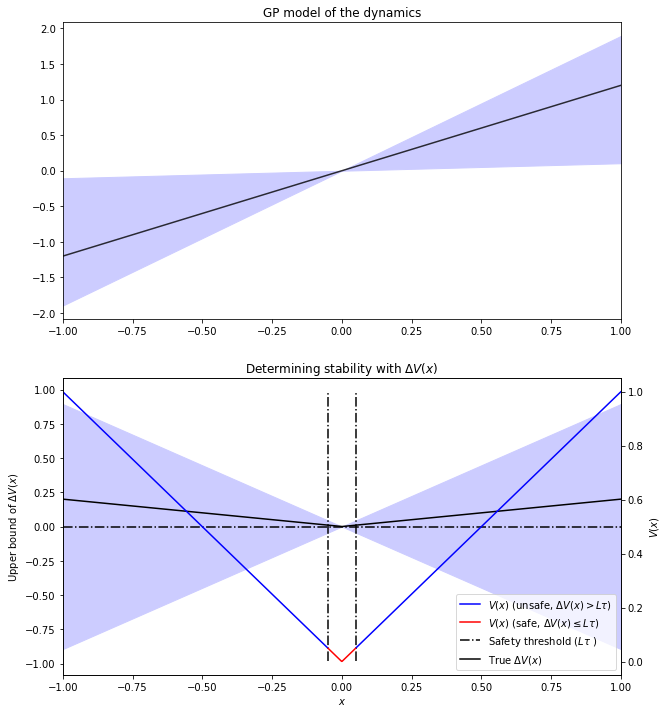

In [5]:
lyapunov.initial_safe_set = np.abs(lyapunov.discretization.all_points.squeeze()) < 0.05

lyapunov.update_safe_set()
noisy_dynamics = lambda x, u, noise: true_dynamics(x, u)
plotting.plot_lyapunov_1d(lyapunov, noisy_dynamics, legend=True)

### Reinforcement learning for the mean dynamics

In [6]:
# mean_dynamics = dynamics.to_mean_function()

reward = safe_learning.QuadraticFunction(linalg.block_diag(-q, -r), name='reward_function')

value_function = safe_learning.Triangulation(policy_disc,
                                             np.zeros(len(policy_disc)),
                                             project=True,
                                             name='value_function')

rl = safe_learning.PolicyIteration(policy, dynamics, reward, value_function)

### Plot the dynamics

Note that the initial policy is just all zeros!!!

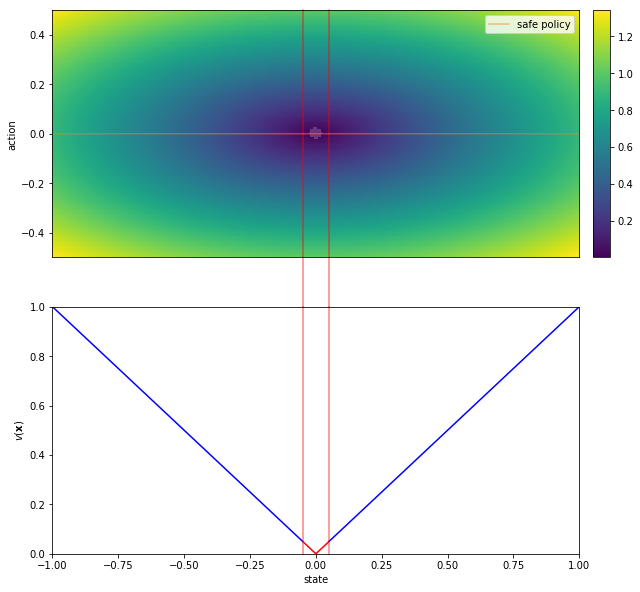

In [7]:
_STORAGE = {}

plotting_discretization = safe_learning.GridWorld(np.vstack((state_limits, action_limits)),
                                                 [num_states, num_actions])

@safe_learning.utilities.with_scope('get_safe_set')
def get_safe_sets(lyapunov, positive=True):
    
    state_disc = lyapunov.discretization
    
    safe_states = state_disc.index_to_state(np.where(lyapunov.safe_set))
    safe_actions = action_disc.all_points
    feed_dict = lyapunov.feed_dict

    state_actions = np.column_stack([arr.ravel() for arr in
                                     np.meshgrid(safe_states, safe_actions, indexing='ij')])
    safe_set = lyapunov.safe_set.reshape(state_disc.num_points)
    
    storage = safe_learning.utilities.get_storage(_STORAGE, index=lyapunov)
    
    if storage is None:
        tf_state_actions = tf.placeholder(safe_learning.config.dtype,
                                          shape=[None, state_actions.shape[1]])
    
        next_states = lyapunov.dynamics(tf_state_actions)
        
        mean, bound = next_states
        bound = tf.reduce_sum(bound, axis=1)
        lv = lyapunov.lipschitz_lyapunov(mean)
        values = tf.squeeze(lyapunov.lyapunov_function(mean), 1) + lv * bound
        maps_inside = tf.less(values, lyapunov.c_max, name='maps_inside_levelset')
    
        state, actions = tf.split(tf_state_actions, [1, 1], axis=1)
        
        dec = lyapunov.v_decrease_bound(state, next_states)
        
        decreases = tf.less(dec, lyapunov.threshold(state))
        
        storage = [('tf_state_actions', tf_state_actions),
                   ('maps_inside', maps_inside),
                   ('mean', mean),
                   ('decreases', decreases)]
        safe_learning.utilities.set_storage(_STORAGE, storage, index=lyapunov)
    else:
        tf_state_actions, maps_inside, mean, decreases = storage.values()

    # Put placeholder values inside feed_dict and evaluate
    feed_dict[tf_state_actions] = state_actions
    maps_inside, mean, decreases = session.run([maps_inside, mean, decreases],
                                               feed_dict=feed_dict)
    
    # Add the mean safe set on top
    if not positive:
        next_state_index = lyapunov.discretization.state_to_index(mean)
        safe_in_expectation = lyapunov.safe_set[next_state_index]
        maps_inside &= safe_in_expectation
        
    maps_inside_total = np.zeros(plotting_discretization.nindex, dtype=np.bool)
    maps_inside_total = maps_inside_total.reshape(plotting_discretization.num_points)
    decreases_total = np.zeros_like(maps_inside_total)
    
    maps_inside_total[safe_set, :] = maps_inside.reshape(len(safe_states), len(safe_actions))
    decreases_total[safe_set, :] = decreases.reshape(len(safe_states), len(safe_actions))

    return maps_inside_total, decreases_total


@safe_learning.utilities.with_scope('plot_lyapunov_2d')
def plot_things():
    fig, axes = plt.subplots(2, 2, figsize=(10, 10), gridspec_kw={'width_ratios': [30, 1]})

    # Hide fake cax
    cax, cax1 = axes[:, 1]
    cax1.set_visible(False)
    cax.set_ylabel('Standard deviation $\sigma$')

    ax0, ax1 = axes[:, 0]
    ax0.set_ylabel('action')
    ax1.set_xlabel('state')
    ax1.set_ylabel('$v(\mathbf{x})$')

    ax1.set_ylim(0, np.max(lyapunov.values))
    ax1.set_xlim(state_limits.squeeze())
    ax0.set_xlim(state_limits.squeeze())
    ax0.set_ylim(action_limits.squeeze())
    ax0.set_xticks([])

    # Hide x-ticks of ax0
    plt.setp(ax0.get_xticklabels(), visible=False)

    # width between cax and main axis
    plt.subplots_adjust(wspace=.05)
    feed_dict = lyapunov.feed_dict
        
    # Plot the dynamics
    states = lyapunov.discretization.all_points
    state_actions = plotting_discretization.all_points
    
    storage = safe_learning.utilities.get_storage(_STORAGE, index=lyapunov)
    if storage is None:
        actions = lyapunov.policy(states)
        next_states = lyapunov.dynamics(state_actions)
        
        storage = [('actions', actions),
                   ('next_states', next_states)]
        
        safe_learning.utilities.set_storage(_STORAGE, storage, index=lyapunov)
    else:
        actions, next_states = storage.values()
    
    mean, bound = session.run(next_states, feed_dict=feed_dict)
    
    # Show the GP variance
    img = ax0.imshow(bound.reshape(plotting_discretization.num_points).T,
                     origin='lower',
                     extent=plotting_discretization.limits.ravel(),
                     aspect='auto')
    
    # Plot the dynamics
    ax0.plot(lyapunov.dynamics.X[:, 0],
             lyapunov.dynamics.X[:, 1], 'x')
    cbar = plt.colorbar(img, cax=cax)

    safe, safe_expanders = get_safe_sets(lyapunov)    
    safe = safe.reshape(plotting_discretization.num_points)
    v_dec = safe_expanders.reshape(plotting_discretization.num_points)
    
    safe_mask = np.ma.masked_where(~safe, safe)
    

    # Overlay the safety feature
    img = ax0.imshow(safe_mask.T,
                     origin='lower',
                     extent=plotting_discretization.limits.ravel(),
                     alpha=0.2,
                     cmap=colors.ListedColormap(['white']),
                     aspect='auto',
                     vmin=0,
                     vmax=1)    
    
    # Overlay the safety feature
    if np.any(v_dec):
        v_dec_mask = np.ma.masked_where(~v_dec, v_dec)
        img = ax0.imshow(v_dec_mask.T,
                         origin='lower',
                         extent=plotting_discretization.limits.ravel(),
                         alpha=0.5,
                         cmap=colors.ListedColormap(['red']),
                         aspect='auto',
                         vmin=0,
                         vmax=1)
    
    is_safe = lyapunov.safe_set
    # Plot the Lyapunov function
    lyap_safe = np.ma.masked_where(~is_safe, lyapunov.values)
    lyap_unsafe = np.ma.masked_where(is_safe, lyapunov.values)

    # Plot lines for the boundary of the safety feature
    x_min_safe = np.min(states[is_safe])
    x_max_safe = np.max(states[is_safe])

    ax1.plot(states, lyap_safe, 'r')
    ax1.plot(states, lyap_unsafe, 'b')

    kw_axv = {'color': 'red',
              'alpha': 0.5}
    ax0.axvline(x=x_min_safe, ymin=-0.2, ymax=1, clip_on=False, **kw_axv)
    ax1.axvline(x=x_min_safe, ymin=0, ymax=1, clip_on=False, **kw_axv)

    ax0.axvline(x=x_max_safe, ymin=-0.2, ymax=1, clip_on=False, **kw_axv)
    ax1.axvline(x=x_max_safe, ymin=0, ymax=1, clip_on=False, **kw_axv)
    
    # Plot the current policy
    actions = actions.eval(feed_dict=feed_dict)
    ax0.step(states, actions, label='safe policy', alpha=0.5)

    ax0.legend()
    plt.show()

# optimize_safe_policy(lyapunov)
lyapunov.update_safe_set()
plot_things()

## Online learning
As we sample within this initial safe set, we gain more knowledge about the system. In particular, we iteratively select the state withing the safe set, $\mathcal{S}_n$, where the dynamics are the most uncertain (highest variance).

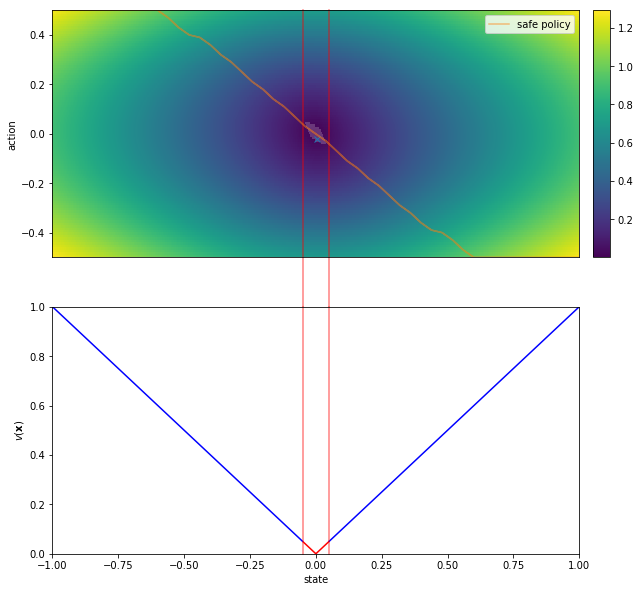

In [8]:
action_space = action_disc.all_points
action_variation = safe_learning.GridWorld(np.array(action_limits) / 20, 11).all_points

rl_opt_value_function = rl.optimize_value_function()
for i in range(3):
    rl_opt_value_function.eval(feed_dict=lyapunov.feed_dict)
    rl.discrete_policy_optimization(action_space)


with tf.variable_scope('add_new_measurement'):
        action_dim = rl.policy.output_dim
        tf_max_state_action = tf.placeholder(safe_learning.config.dtype,
                                             shape=[1, safety_disc.ndim + action_dim])
        tf_measurement = true_dynamics(tf_max_state_action)
        
def update_gp():
    """Update the GP model based on an actively selected data point."""
    # Optimize the value/function and policy
    rl_opt_value_function.eval(feed_dict=lyapunov.feed_dict)
    rl.discrete_policy_optimization(action_space)
    
    # Get a new sample location
    lyapunov.update_safe_set()
    max_state_action, _ = safe_learning.get_safe_sample(lyapunov,
                                                        action_variation,
                                                        action_limits)

    # Obtain a measurement of the true dynamics
    lyapunov.feed_dict[tf_max_state_action] = max_state_action
    measurement = tf_measurement.eval(feed_dict=lyapunov.feed_dict)

    # Add the measurement to our GP dynamics
    lyapunov.dynamics.add_data_point(max_state_action, measurement)
    

update_gp()
plot_things()

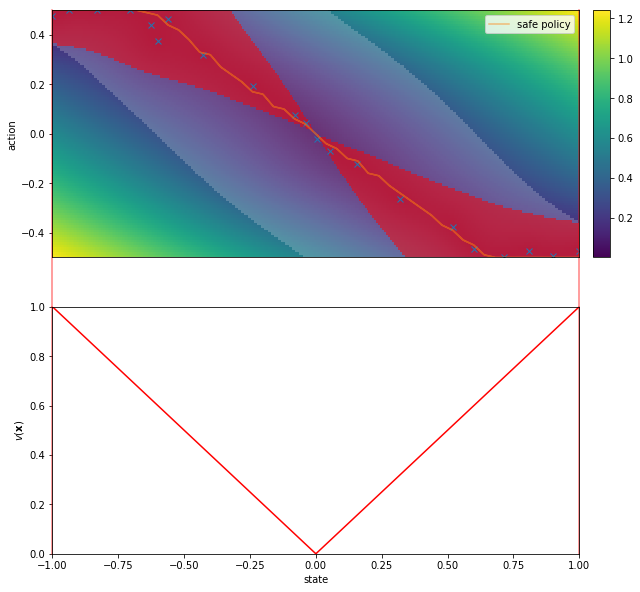

In [9]:
for i in range(20):
    update_gp()
    
lyapunov.update_safe_set()
plot_things()

In [10]:
plotting.show_graph(tf.get_default_graph())